# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler

In [53]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Reading files

In [3]:
common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/"

# Rl = 90; N=256
# folder_in = "dt_003_T_25/"
# run_files=[30, 51, 79, 86, 85, 77, 89]
# spec_component = "avg"

Rl = 60; N=128
folder_in = "big_ts/real_simplified_large_window/"
run_files=[885]
spec_component = "xx"

# folder_in = "dt02/"
# run_files=[2794]

# folder_in = "big_ts/real_kstar/"
# run_files=[1476]

# Rl = 160; N=512
# folder_in = ""
# run_files=[13,13,13]

correlation_type = "two_point_corr"
spec_type = "lin"

nb_of_runs = len(run_files)

# read average correlation files
for run_index in list(range(nb_of_runs)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    if (run_files[run_index] < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
    file_data = []
    averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            temp_array_line = [t * averaging_weight for t in temp_array_line]
            file_data.append(temp_array_line)  
    if (run_index == 0) : 
        accumulated_data = file_data.copy()
    else : 
        accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
#averaging_coef = 1.0/nb_of_runs
averaging_coef = 1.0
k = np.array(accumulated_data[0])*averaging_coef
nb_of_modes = np.array(accumulated_data[1])*averaging_coef

average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
for i in list(range(average_data.shape[0])) : 
    average_data[i, :] = np.array(accumulated_data[i+2])*averaging_coef
t = average_data[:,0]
correlation_mean = np.array(average_data[:,1:])
del average_data, file_data, accumulated_data

correlation_type = "two_point_corr_variance"
spec_type = "lin"
#read variance files
for run_index in list(range(nb_of_runs)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    if (run_files[run_index] < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
    file_data = []
    averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            temp_array_line = [t * averaging_weight for t in temp_array_line]
            file_data.append(temp_array_line)
    if not('accumulated_data' in dir()) : 
        accumulated_data = file_data.copy()
    else : 
        accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
averaging_coef = 1.0
average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
for i in list(range(average_data.shape[0])) : 
    average_data[i, :] = np.array(accumulated_data[i+2])*averaging_coef
correlation_var = np.array(average_data[:,1:])

del average_data, file_data, accumulated_data

# Define parameters

In [4]:
# PARAMETERS
pi = np.pi
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025   
    L=2.65  
    dissipation_rate=2.24565e-06
elif (Rl == 160) :
    lmbda = 0.161345 
    eta = 0.006436  
    L = 2.23
    dissipation_rate = 0.00058328   
elif (Rl == 240) :
    lmbda = 0.09986 
    eta = 0.003176  
    L = 2.3
t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True

# Normalization

In [5]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
if normalization_status :
#     k_norm_coef = L
#     t_norm_coef = 1.0/t0
#     t=t*t_norm_coef
#     k=k*k_norm_coef
#     spatial_scales = 1.0/k_norm_coef * spatial_scales
    
    normalization = (correlation_mean[0,:])**(-1)
else : 
    normalization = np.ones(wavenumbers_length)

wn_scales = 2.0*np.pi/spatial_scales
kL = 2.0*pi/L; klmbda = 2.0*pi/lmbda; keta = 2.0*pi/eta

std_norm = np.copy(correlation_var)
for ik in list(range(wavenumbers_length)) : 
    std_norm[:,ik] = np.sqrt(correlation_var[:,ik])/np.abs(correlation_mean[:,ik])

mean_sqr = correlation_var + correlation_mean**2
snr = correlation_var/mean_sqr

# Plotting params

In [6]:
kmin = 5
kmax = 40
nb_of_curves = 20
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

plt.rc('axes', labelsize=12)  
plt.rc('axes', titlesize=12)  
plt.rc('legend', fontsize=12)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rc('axes', prop_cycle=cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors)))

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


# Spatial compensated spectrum from C_2(t=0,k)

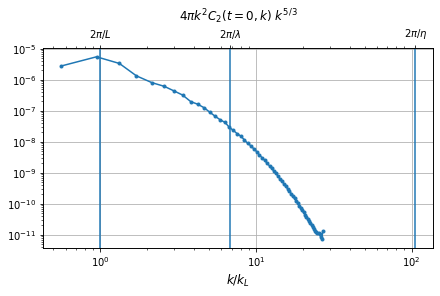

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
kinetic_energy = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    #coefficient = 4.0*np.pi*k[ik]*k[ik]
    coefficient = 4.0*np.pi*k[ik]*k[ik]/nb_of_modes[ik]
    kinetic_energy[ik] = correlation_mean[0,ik]*coefficient
ax.plot(k/kL, kinetic_energy*k**(5.0/3.0), '.-', label='Spectrum')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', title=r'$4\pi k^2 C_2(t=0,k) \ k^{5/3}$')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

In [8]:
np.searchsorted(k, wn_scales[1])

16

# Plot time correlation functions

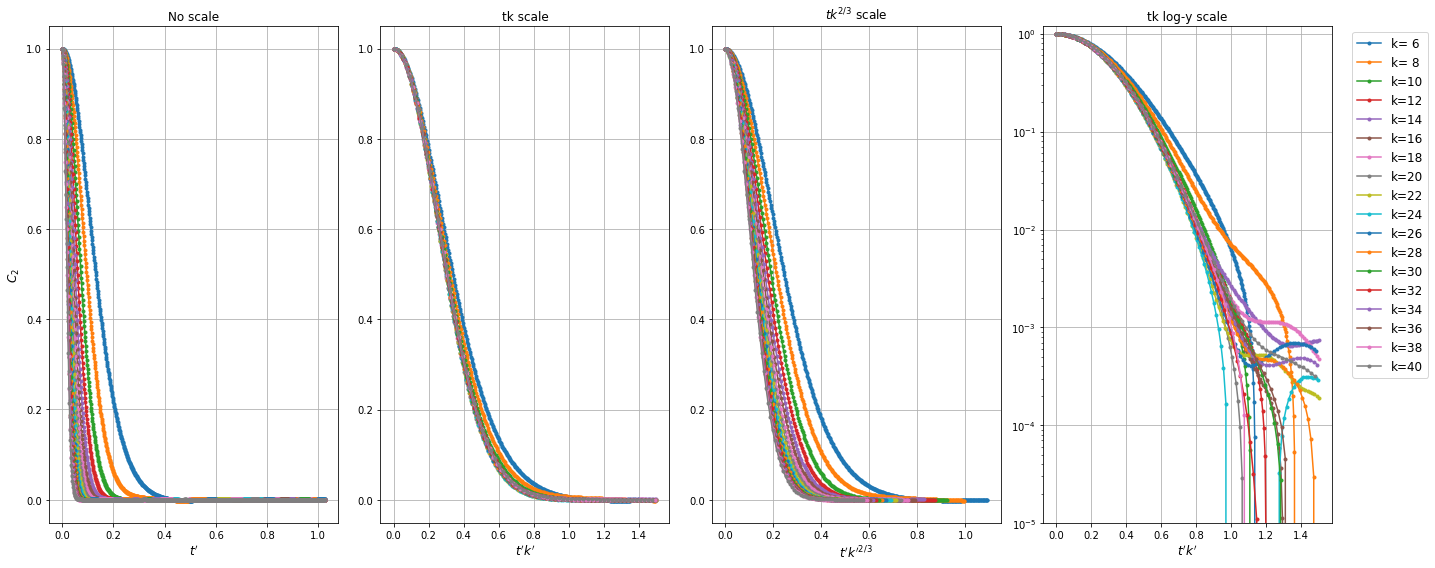

In [9]:
tk1 = 0.0
tk2 = 1.5

fig, (norm_scale, tk_scale, tk23_scale, log_scale) = plt.subplots(nrows=1, ncols=4,figsize=(20,8))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2)
    norm_scale.plot(t/t0, correlation_mean[:,ik]*normalization[ik], '.-')
    tk_scale.plot(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik]*normalization[ik], '.-')
    tk23_scale.plot(t[a:b]/t0*(k[ik]/kL)**(2.0/3.0), correlation_mean[a:b,ik]*normalization[ik], '.-')
    log_scale.semilogy(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik]*normalization[ik], '.-', label='k=%2.f' % (k[ik]))
norm_scale.set(title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$'); tk23_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2]); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

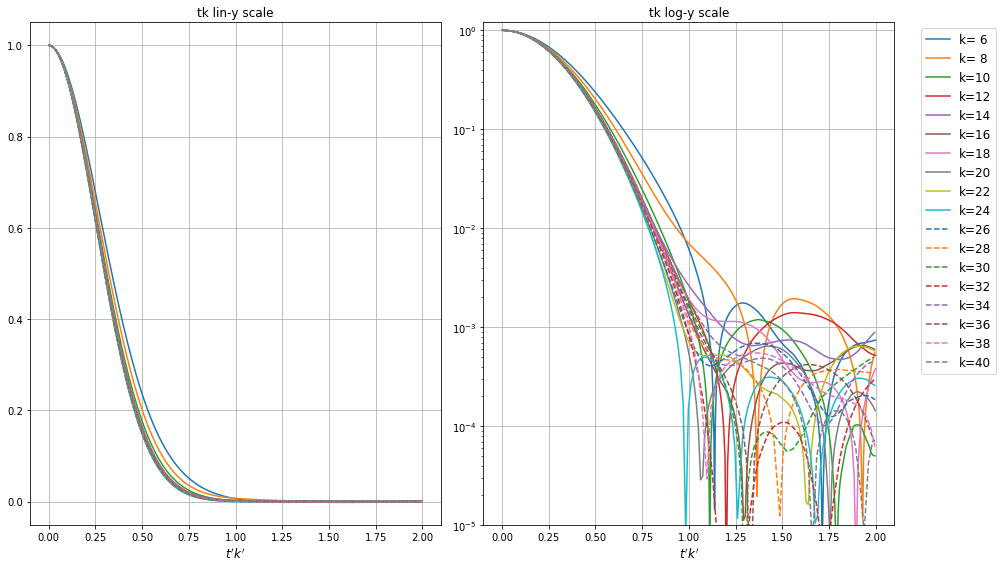

In [10]:
tk1 = 0.0
tk2 = 2.0

fig, (lin_scale, log_scale) = plt.subplots(nrows=1, ncols=2,figsize=(14,8))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2)
    lin_scale.plot(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik]*normalization[ik])
    log_scale.semilogy(t[a:b]/t0*(k[ik]/kL), np.abs(correlation_mean[a:b,ik]*normalization[ik]), label='k=%2.f' % (k[ik]))
lin_scale.set(title='tk lin-y scale', xlabel=r'$t^\prime k^\prime$'); lin_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2]); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


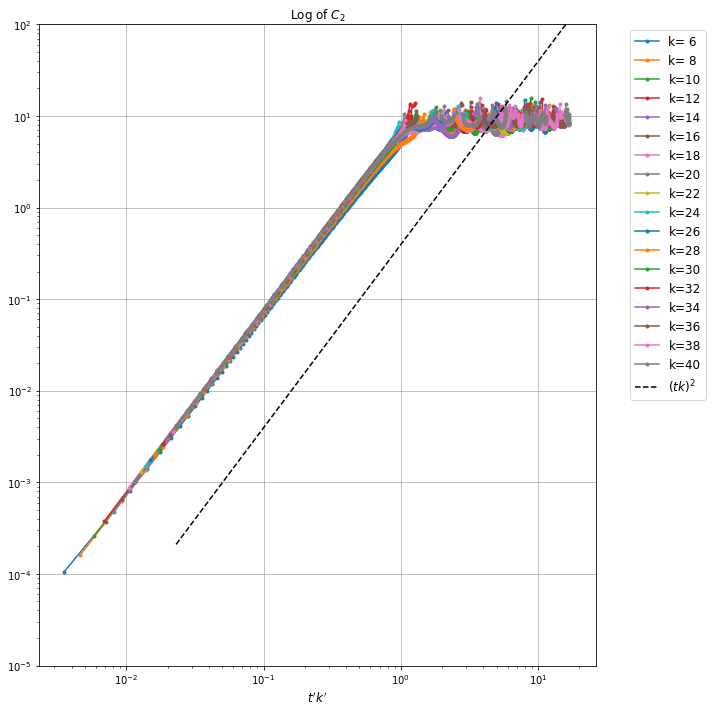

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
for ik in indices_of_k_to_plot :
    ax.plot(t[1:]/t0*(k[ik]/kL), -(np.log(correlation_mean[1:,ik]*normalization[ik])), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
ax.plot(t[1:]/t0*k[ik]/kL, 10e-3*np.power(t[1:]/t0*k[ik]*L, 2.0), 'k--', label=r'$(tk)^2$')
ax.set(xscale='log', yscale='log', xlabel=r'$t^\prime k^\prime$',title=r'Log of $C_2$')
ax.set(ylim=[10e-6, 100])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


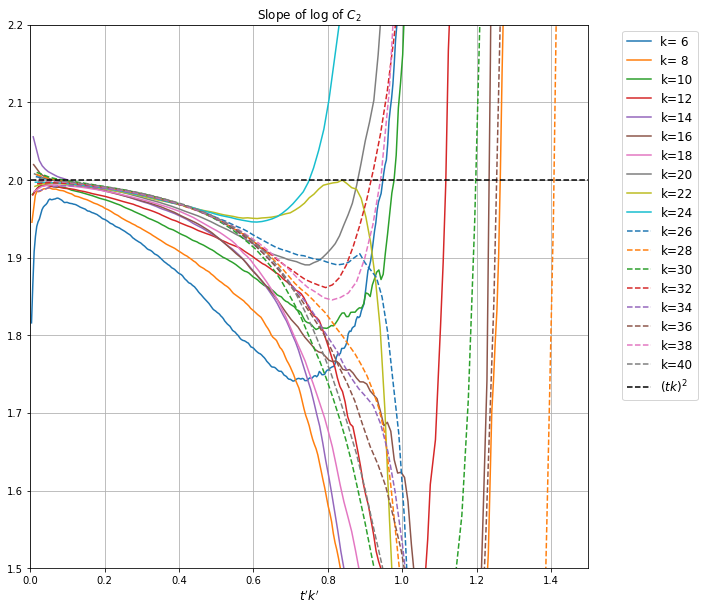

In [12]:
# check the slope of the curve
resampling = 2

fig, ax = plt.subplots(figsize=(10,10))
for ik in indices_of_k_to_plot :
    x = np.log(t[1:]/t0*k[ik]/kL)
    f = np.log(-(np.log(correlation_mean[1:,ik]*normalization[ik])))
    slope = np.gradient(f, x)
    ax.plot(np.exp(x[:-2:]), slope[:-2:], label='k=%2.f' % (k[ik]))
ax.plot(x-1, 2*np.ones_like(x), 'k--', label=r'$(tk)^2$')
ax.set(xlabel=r'$t^\prime k^\prime$',title=r'Slope of log of $C_2$', yscale='linear')
ax.set(ylim=[1.5,2.2], xlim=[0,1.5])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Large time lags (new normalization coef in the tail)

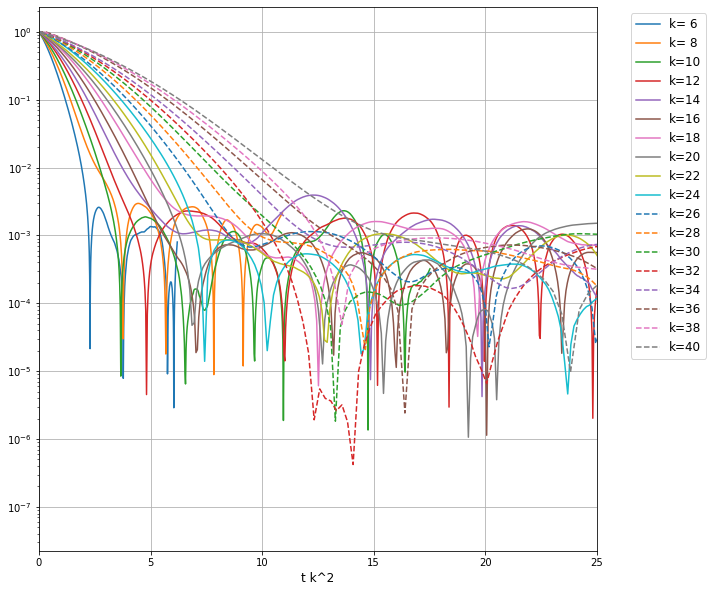

In [13]:
# new regime starts at
tk_c = 0.25

fig, ax = plt.subplots(figsize=(10,10))
for ik in indices_of_k_to_plot :
    ic = np.searchsorted(t/t0*k[ik]/kL, tk_c)
    new_normalization = 1.0/correlation_mean[ic,ik]
    tc = tk_c/(k[ik]/kL)
    ax.plot((t[ic::]/t0-tc)*(k[ik]/kL)**2.0, np.abs(correlation_mean[ic::,ik]*new_normalization), label='k=%2.f' % (k[ik]))
ax.set(yscale='log'); ax.grid()
ax.set(xlim=[0,25])
#ax.set(ylim=[10e-5, 1.5])
ax.set(xlabel='t k^2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Averaged curves

In [14]:
avg_c2 = np.zeros(shape=t_length, dtype=float)
avg_counter = np.zeros(shape=t_length, dtype=float)

ikrange = np.arange(10,60)
#ikrange = np.arange(10,150)

xnew = t/t0*k[ikrange[-1]]/kL
for ik in ikrange : 
    x = t/t0*(k[ik]/kL)
    f = interpolate.interp1d(x, np.abs(correlation_mean[::,ik]*normalization[ik]), bounds_error=False)
    ynew = f(xnew)
    for it in list(range(t_length)) :
        if (~np.isnan(ynew[it])) :
            avg_c2[it] = avg_c2[it] + ynew[it]
            avg_counter[it] = avg_counter[it] + 1
avg_c2 = avg_c2/avg_counter

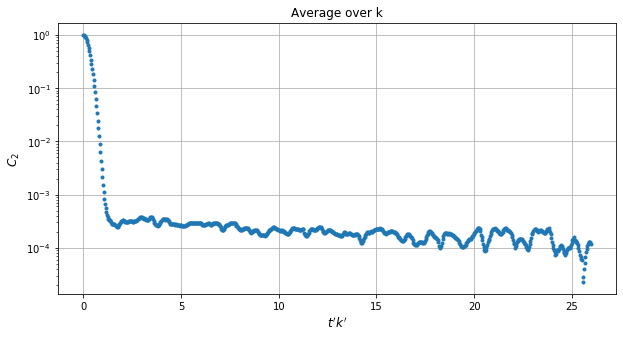

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xnew, avg_c2, '.')
ax.set(yscale='log', xlabel=r'$t^\prime k^\prime$', ylabel=r'$C_2$', title='Average over k'); ax.grid()

plt.show()

# Statistical error

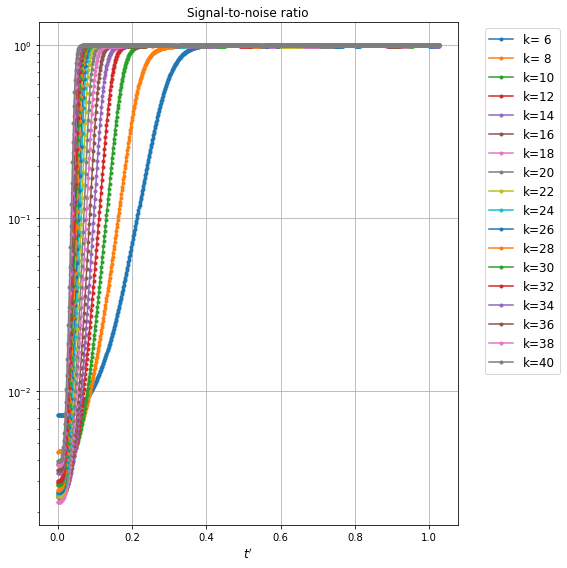

In [16]:
fig, (log_scale) = plt.subplots(figsize=(8,8))
for ik in indices_of_k_to_plot :
    log_scale.semilogy(t/t0, snr[:,ik], '.-', label='k=%2.f' % (k[ik]))
log_scale.set(title='Signal-to-noise ratio', xlabel=r'$t^\prime$'); log_scale.grid()
#log_scale.set(ylim=[10e-3, 1])
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

# Cut the correlation function

In [17]:
threshold = 0.5

correlation_cut = np.copy(correlation_mean)
for ik in list(range(wavenumbers_length)) : 
    np.place(correlation_cut[:,ik], snr[:,ik]>threshold, np.nan)

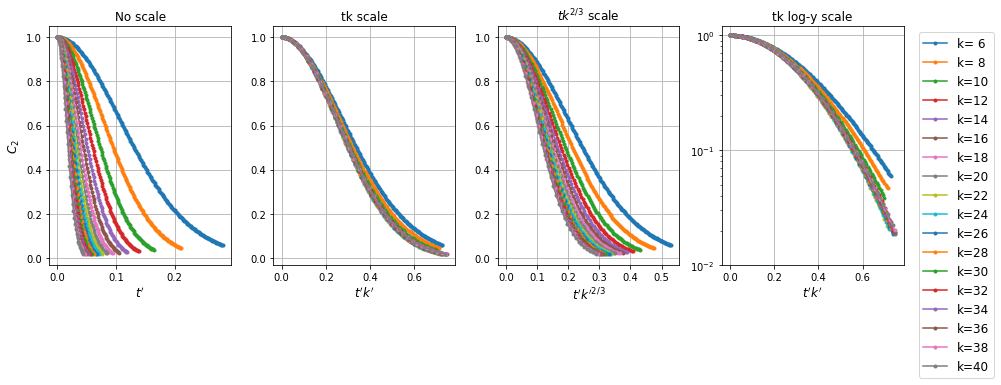

In [18]:
tk1 = 0.0
tk2 = 3.0

fig, (norm_scale, tk_scale, tk23_scale, log_scale) = plt.subplots(nrows=1, ncols=4,figsize=(14,5))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2)
    norm_scale.plot(t/t0, correlation_cut[:,ik]*normalization[ik], '.-')
    tk_scale.plot(t[a:b]/t0*(k[ik]/kL), correlation_cut[a:b,ik]*normalization[ik], '.-')
    tk23_scale.plot(t[a:b]/t0*(k[ik]/kL)**(2.0/3.0), correlation_cut[a:b,ik]*normalization[ik], '.-')
    log_scale.semilogy(t[a:b]/t0*(k[ik]/kL), correlation_cut[a:b,ik]*normalization[ik], '.-', label='k=%2.f' % (k[ik]))
norm_scale.set(title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$'); tk23_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$', ylim=[1e-2, 1.2]); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

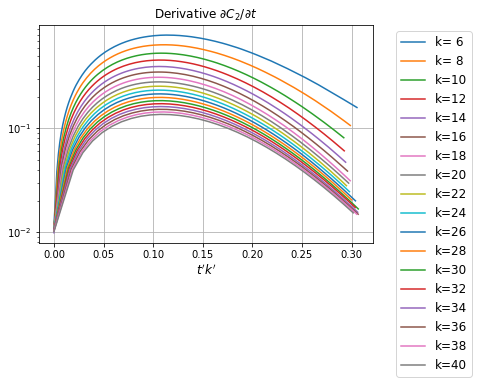

In [19]:
#derivative of C_2
for ik in indices_of_k_to_plot :
    resampling = 1
    x = t[::resampling]/t0
    f = correlation_cut[::resampling,ik]*normalization[ik]
    #f = -np.log(np.abs(correlation_mean[::resampling,ik]*normalization[ik]))
    deriv1 = np.gradient(f, x)
    #np.place(slope, np.abs(slope)>0.7, np.nan)
    plt.plot(x*k[ik]/kL**2.0, -deriv1/(k[ik]/kL)**2.0, '-', label='k=%2.f' % k[ik])
# plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
# plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
plt.xlabel(r'$t^\prime k^\prime$')
plt.title(r'Derivative $\partial C_2 / \partial t$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')
plt.yscale('log')
#plt.xlim([0, 1.0])
# plt.ylim([-1, 1])
plt.grid()
plt.show()

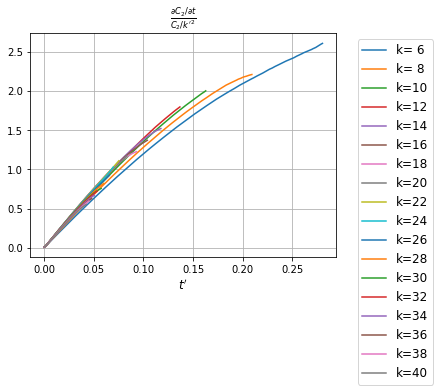

In [20]:
#derivative of ln(C_2)
fig, ax = plt.subplots(constrained_layout=True, figsize=(6,5))
for ik in indices_of_k_to_plot :
    resampling = 1
    x = t[::resampling]/t0
    y = correlation_cut[::resampling,ik]*normalization[ik]
    
    #cut the correlation after 1st zero
#     np.place(y, np.abs(y)<10e-4, np.nan)
#     index_of_first_zero = np.nonzero(~np.isfinite(y))[0][0]
#     y[index_of_first_zero::] = np.nan
    
    #compute derivative
    deriv1 = np.gradient(y, x)
    
    #plot
    ax.plot(x, -deriv1/y/((k[ik]/kL)**2.0), '-', label='k=%2.f' % k[ik])
#ax.plot(x, 2.3*x, 'k-')
ax.set(xlabel=r'$t^\prime$', title=r'$\frac{\partial C_2 / \partial t}{C_2 / {k^\prime}^2}$'); ax.grid()
ax.set(xscale='linear', yscale='linear') 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.set(xlim=[0, 0.6], ylim=[0, 1.0])

plt.show()

In [21]:
# # #2nd derivative of ln(C_2)
# for ik in indices_of_k_to_plot :
#     resampling = 1
#     x = t[::resampling]/t0
#     f = -np.log(np.abs(correlation_cut[::resampling,ik]*normalization[ik]))
#     deriv1 = np.gradient(f, x)
#     np.place(deriv1, np.abs(deriv1/k[ik]**2.0)>1.0, np.nan)
#     deriv2 = np.gradient(deriv1/k[ik]**2.0, x)
#     np.place(deriv2, np.abs(deriv2)>5, np.nan)
#     plt.plot(x, deriv2, '.-', label='k=%2.f' % k[ik])
# # plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
# # plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
# plt.xlabel(r'$t^\prime$'), plt.ylabel('slope')
# plt.title(r'2nd derivative of $\ln(C_2)$')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xscale('linear')
# plt.xlim([0, 1.0])
# plt.ylim([-1, 5.0])
# plt.grid()
# plt.show()

# Integral decorrelation time scale

In [22]:
integral_decorrelation_time = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    integral_decorrelation_time[ik] = np.trapz(np.nan_to_num(correlation_cut[:,ik]*normalization[ik]), x=t)

In [23]:
#microscale_time 
microscale_time = np.zeros(shape=wavenumbers_length, dtype=float)

#second order right side finite difference scheme for the second derivative
deltaT = t[1] - t[0]
for ik in list(range(wavenumbers_length)) : 
    u = correlation_mean[:,ik]*normalization[ik]
    derivative = (2.0*u[0] - 5.0*u[1] + 4.0*u[2] - u[3])/(deltaT*deltaT)
    microscale_time[ik] = (-derivative)**(-0.5)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [24]:
#integral time without microscale
large_lag_integral_decorrelation_time = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    index_of_end_of_microsclace = np.searchsorted(t, 1.1*microscale_time[ik])
    large_lag_integral_decorrelation_time[ik] = np.trapz(correlation_mean[index_of_end_of_microsclace:,ik]*normalization[ik], x=t[index_of_end_of_microsclace:])

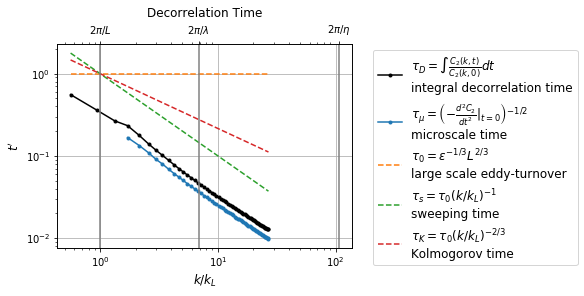

In [25]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax.plot(k/kL, integral_decorrelation_time/t0,  'k.-', label=r"$\tau_D = \int \frac{C_2(k, t)}{C_2(k, 0)} dt$" "\nintegral decorrelation time")
ax.plot(k/kL, microscale_time/t0,  '.-', label=r"$\tau_\mu = \left(- \frac{d^2 C_2}{d t^2} |_{t=0} \right)^{-1/2}$""\nmicroscale time")
ax.plot(k/kL, np.ones_like(k), '--', label=r"$\tau_0 = \epsilon^{-1/3} L^{2/3}$""\nlarge scale eddy-turnover")
ax.plot(k/kL, np.power(k/kL, -1.0), '--', label=r"$\tau_s = \tau_0 (k/k_L)^{-1}$""\nsweeping time")
ax.plot(k/kL, np.power(k/kL, -2.0/3.0), '--', label=r"$\tau_K =  \tau_0 (k/k_L)^{-2/3}$""\nKolmogorov time")
#ax.plot(k*L, np.power(k*L, -2.0), '--', label=r'$\tau_K =  \tau_0 (k L)^{-2}$')
ax.set(xscale='log', yscale='log', xlabel=r'$k/k_L$', ylabel=r'$t^{\prime}$', title='Decorrelation Time')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

vertical_lines = wn_scales/kL
for line in vertical_lines : ax.axvline(x=line, color='gray')
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

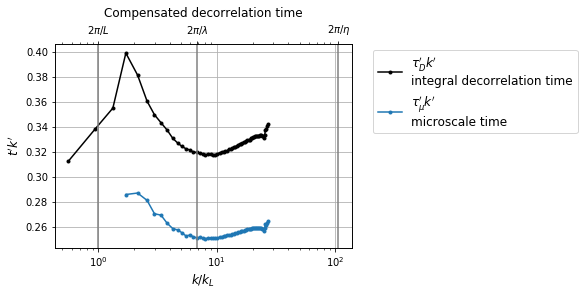

In [26]:
#compensate by k
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax.plot(k/kL, integral_decorrelation_time/t0*k/kL,  'k.-', label=r"$\tau_D^\prime k^\prime$" "\nintegral decorrelation time")
ax.plot(k/kL, microscale_time/t0*k/kL,  '.-', label=r"$\tau_\mu^\prime k^\prime$""\nmicroscale time")
#ax.plot(k*L, np.power(k*L, -2.0), '--', label=r'$\tau_K =  \tau_0 (k L)^{-2}$')
ax.set(xscale='log', yscale='log', xlabel=r'$k/k_L$', ylabel=r'$t^\prime k^\prime$', title='Compensated decorrelation time')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

vertical_lines = wn_scales/kL
for line in vertical_lines : ax.axvline(x=line, color='gray')
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='linear', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

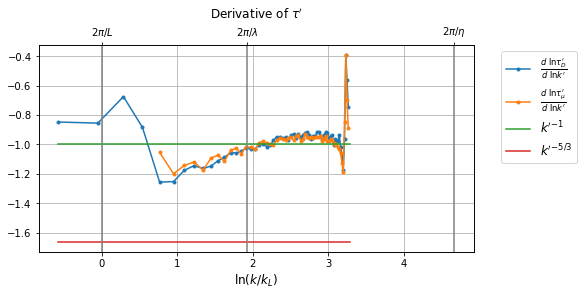

In [27]:
# check the slope time scales dependence
resampling = 1
x = np.log(k[::resampling]/kL)
deriv_td = np.gradient(np.log(integral_decorrelation_time[::resampling]/t0), x)
deriv_tmu = np.gradient(np.log(microscale_time[::resampling]/t0), x)

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax.plot(x[:-2:], deriv_td[:-2:], '.-', label=r'$\frac{d \ \ln \tau_D^\prime}{d \ \ln k^\prime}$')
ax.plot(x[:-2:], deriv_tmu[:-2:], '.-', label=r'$\frac{d \ \ln \tau_\mu^\prime}{d \ \ln k^\prime}$')
ax.plot(x[::], -1*np.ones_like(x[::]), '-',label=r'${k^\prime}^{-1}$')
ax.plot(x[::], -5/3*np.ones_like(x[::]), '-', label=r'${k^\prime}^{-5/3}$')
ax.set(xlabel=r'$\ln (k/k_L)$', xscale='linear', yscale='linear', title=r'Derivative of $\tau^\prime$')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

vertical_lines = np.log(wn_scales/kL)
for line in vertical_lines : ax.axvline(x=line, color='gray')
ax2 = ax.twiny()
ax2.set(xscale='linear', yscale='linear', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

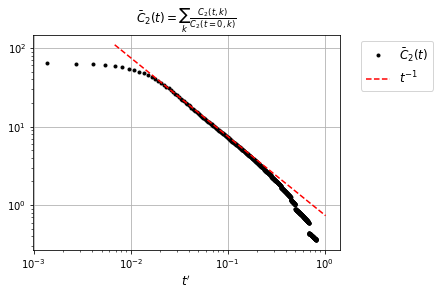

In [28]:
#sum over k
sum_corr = np.sum(np.nan_to_num(correlation_cut)*normalization,axis=1)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t/t0, sum_corr, 'k.',label=r'$\bar{C}_2 (t)$')
plt.plot(t[5:]/t0, 110*np.power(t[5:], -1.0), 'r--', label=r'$t^{-1}$')
ax.set(xscale='log', yscale='log', xlabel=r'$t^\prime$',title=r'$\bar{C}_2 (t) = \sum_k \frac{C_2(t, k)}{C_2(t=0, k)} $')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation fit

In [29]:
# Define the functions to fit

def gaussian(x, a, b):   
    return a * np.exp(-b * x**2) 
gaussian_nb_of_params = 2

# exponential
def exponent_function(x, a, b, c):   
    return a * np.exp(-b * x) + c
exponent_nb_of_params = 3

# exponential
def exponent_function2(x, a, b):   
    return a * np.exp(-b * x) 
exponent2_nb_of_params = 2

### Short times - Gaussian

In [30]:
tk1_gauss = 0.0
tk2_gauss = 0.25

optim_coef1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params), dtype=float)
cov_matrix1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params, gaussian_nb_of_params), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1_gauss)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2_gauss)
    xdata = t[a:b]/t0*k[ik]/kL   # t'k' variable
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_cut[a:b, ik]*normalization[ik]
    try :
        optim_coef1[ik, :], cov_matrix1[ik, :, :] = curve_fit(gaussian, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef1[ik,:].fill(np.nan)
        continue

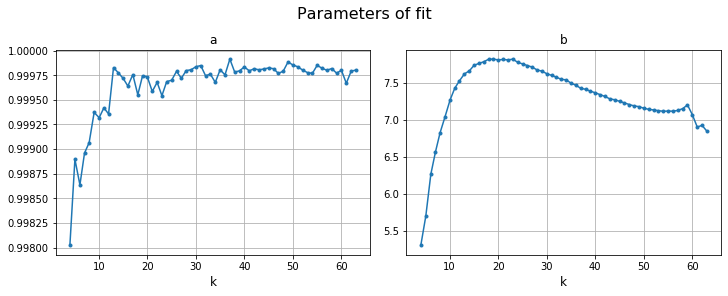

In [31]:
# plot fitting coeffiecients
ik1 = 3; ik2 = wavenumbers_length-1

fig, (ax_a, ax_b) = plt.subplots(nrows=1, ncols=2,figsize=(10,4), constrained_layout=True)
ax_a.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 0], '.-')
ax_b.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 1], '.-')
#ax_c.plot(k[ik1:ik2]/k_norm_coef, optim_coef1[ik1:ik2, 2], '.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k', xscale='linear'); ax_b.grid()
#ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

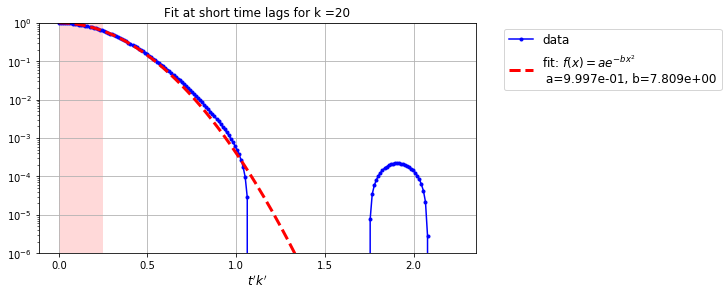

In [32]:
# Example of the gaussian fit for one wavenumber
ik = 19
a = np.searchsorted(t/t0*k[ik]/kL, tk1_gauss)
b = np.searchsorted(t/t0*k[ik]/kL, tk2_gauss+2)
coef_vector = optim_coef1[ik,:]
x = t[a:b]/t0*k[ik]/kL

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
ax.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'b.-', label='data')
ax.plot(x, gaussian(x, *coef_vector), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(coef_vector))
ax.set(xlabel=r'$t^\prime k^\prime$', title='Fit at short time lags for k =%2.f' % (k[ik]));  ax.grid()
ax.set(yscale="log", ylim=[10e-7, 1.0])
ax.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

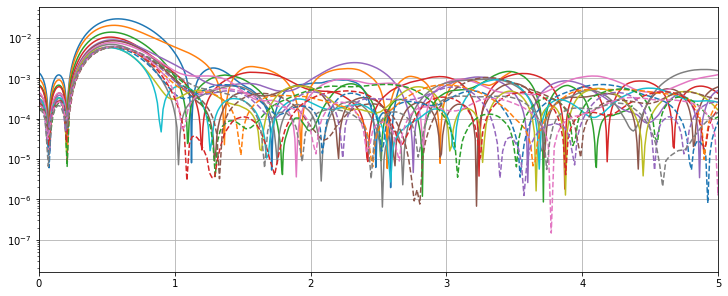

In [33]:
#difference between the correlation and the gaussian fit
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
for ik in indices_of_k_to_plot :
    x = t/t0*(k[ik]/kL)
    ax.plot((t/t0)*(k[ik]/kL), np.abs(correlation_mean[::,ik]*normalization[ik]-gaussian(x, *optim_coef1[ik,:])))
ax.set(yscale='log'); ax.grid()
#ax.set(ylim=[10e-6,1.02])
ax.set(xlim=[0,5.0])
plt.show()

### Long time lags

In [34]:
# fitting range : 
tk1_long = 0.75
tk2_long = 1.0

optim_coef2 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
cov_matrix2 = np.ndarray(shape=(wavenumbers_length, 3, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1_long)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2_long)
    xdata = t[a:b]/t0*(k[ik]/kL)
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_mean[a:b, ik]*normalization[ik]
    try :
        optim_coef2[ik, :], cov_matrix2[ik,:,:] = curve_fit(exponent_function, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef2[ik,:].fill(np.nan)
        continue
    max_param_std = 100
    if (np.count_nonzero(np.sqrt(np.diag(cov_matrix2[ik,:,:])>max_param_std)) > 0) :
        print('point out ik = ', ik)
        cov_matrix2[ik,:,:].fill(np.nan)
        optim_coef2[ik,:].fill(np.nan)

Failed optimization for ik =  0
point out ik =  21


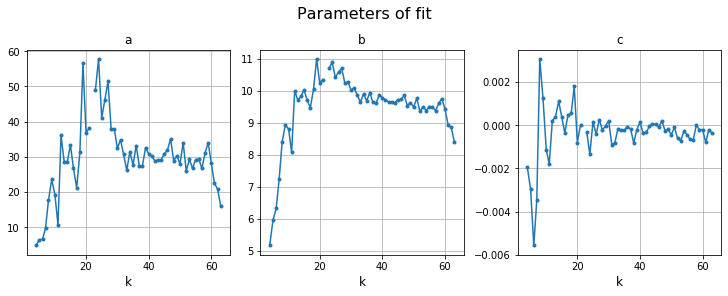

In [35]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 3; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

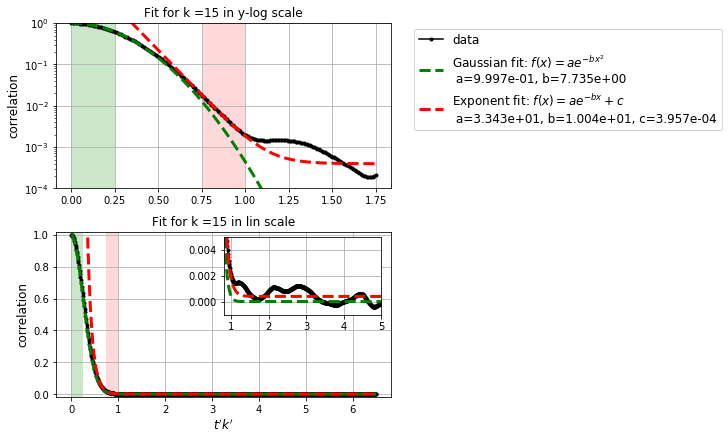

In [36]:
# Example of the exponential fit for one wavenumber
ik = 14
a = np.searchsorted(t/t0*k[ik]/kL, 0)
b = np.searchsorted(t/t0*k[ik]/kL, tk1_long+1)
coef_vector = optim_coef2[ik,:]

fig, (ax_log, ax_lin) = plt.subplots(nrows=2, ncols=1, figsize=(10,6), constrained_layout=True)
#fig, (ax_log) = plt.subplots(figsize=(12,4), constrained_layout=True)
x = t[a:b]/t0*k[ik]/kL
ax_log.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_log.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef1[ik,:]))
ax_log.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(ylim=(10e-5,1.02), yscale="log", ylabel='correlation', title='Fit for k =%2.f' % (k[ik]) +' in y-log scale'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

a = np.searchsorted(t/t0*k[ik]/kL, 0)
b = np.searchsorted(t/t0*k[ik]/kL, tk1_long+10)
x = t[a:b]/t0*k[ik]/kL
ax_lin.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_lin.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef1[ik,:]))
ax_lin.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3)
ax_lin.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_lin.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_lin.set(ylim=(-0.02,1.02), xlabel=r'$t^\prime k^\prime$', ylabel='correlation',title='Fit for k =%2.f' % (k[ik]) +' in lin scale'); ax_lin.grid()

zoom = ax_lin.inset_axes([0.5, 0.5, 0.47, 0.47])
zoom.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
zoom.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3)
zoom.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3)
#zoom.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
#zoom.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
zoom.set(ylim=(-0.001,0.005), xlim=(0.8,5.0), yscale="linear"); zoom.grid()

plt.show()

### Fitting of avg

In [37]:
avg_c2 = np.zeros(shape=t_length, dtype=float)
ikrange = np.arange(12,60)

xnew = t/t0*k[ikrange[0]]/kL
for ik in ikrange : 
    f = interpolate.interp1d(t/t0*k[ik]/kL, correlation_mean[::,ik]*normalization[ik])
    ynew = f(xnew)
    avg_c2 = avg_c2 + ynew
avg_c2 = avg_c2/ikrange.shape[0]

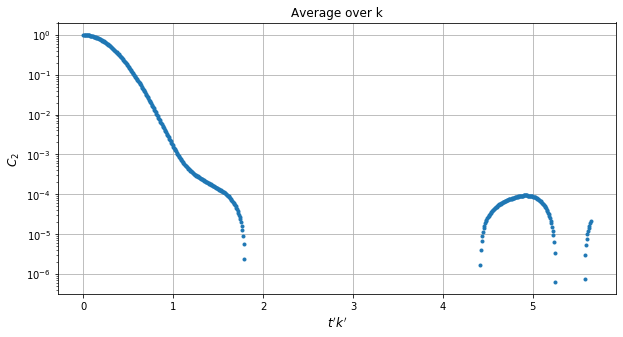

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xnew, avg_c2, '.')
ax.set(yscale='log', xlabel=r'$t^\prime k^\prime$', ylabel=r'$C_2$', title='Average over k'); ax.grid()

plt.show()

In [39]:
tk1_gauss = 0.0
tk2_gauss = 0.25
tk1_long = 0.75
tk2_long = 1.0

a = np.searchsorted(xnew, tk1_gauss)
b = np.searchsorted(xnew, tk2_gauss)
xdata = xnew[a:b]   # t'k' variable
ydata = avg_c2[a:b]
optim_coef_avg_short = curve_fit(gaussian, xdata, ydata)[0]

a = np.searchsorted(xnew, tk1_long)
b = np.searchsorted(xnew, tk2_long)
xdata = xnew[a:b]   
ydata = avg_c2[a:b]
optim_coef_avg_long = curve_fit(exponent_function, xdata, ydata)[0]


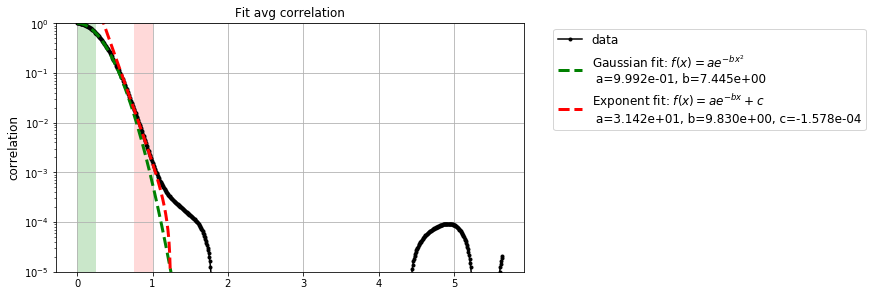

In [40]:
fig, (ax_log) = plt.subplots(figsize=(12,4), constrained_layout=True)
x = xnew
ax_log.plot(x, avg_c2, 'k.-', label='data')
ax_log.plot(x, gaussian(x, *optim_coef_avg_short), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef_avg_short))
ax_log.plot(x, exponent_function(x, *optim_coef_avg_long), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_avg_long))
#ax_log.plot(x, exponent_function2(x, *optim_coef_avg_long), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef_avg_long))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(yscale="log", ylabel='correlation', title='Fit avg correlation'); ax_log.grid()
ax_log.set(ylim=(10e-6,1.02))
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# FFT in time of correlation C_2(t,k)

## Compute and plot FFT

In [41]:
delta = t[1]-t[0]
omega = np.fft.fftfreq(t_length, delta)*2.0*np.pi
spectrum_of_correlation = np.ndarray(shape=(t_length, wavenumbers_length), dtype=complex)
for ik in list(range(wavenumbers_length)) :
    yf = np.fft.fft(correlation_mean[:,ik])
    spectrum_of_correlation[:, ik] = 1.0/t_length * yf

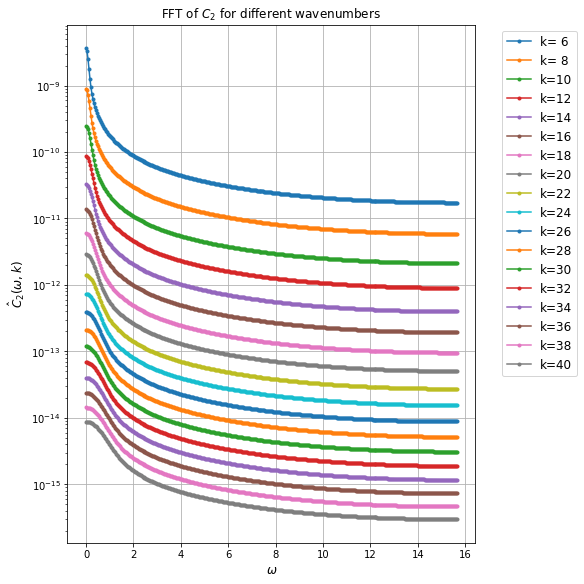

In [42]:
#plot \hat{C}_2(w, k) = FFT [C_2(t, k)]
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
for ik in indices_of_k_to_plot :
    ax.plot(omega[0:t_length//2], np.absolute(spectrum_of_correlation[0:t_length//2, ik]), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
#plt.plot(omega[1:t_length//2], 10e-6*omega[1:t_length//2]**(-1), 'k-', label=r'$\omega^{-1}$')
ax.set(xscale='linear', yscale='log', xlabel=r'$\omega$', ylabel=r'$\hat{C}_2 (\omega, k)$', title=r'FFT of $C_2$ for different wavenumbers')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

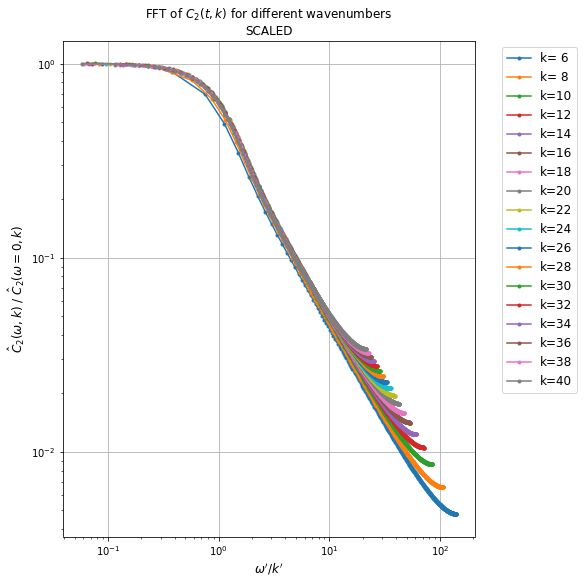

In [43]:
#plot SCALED \hat{C}_2(w, k) = FFT [C_2(t, k)]
w0 = 2.0*pi/t0
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
for ik in indices_of_k_to_plot :
    vertical_scale = 1.0/np.absolute(spectrum_of_correlation[0, ik])
    ax.plot(omega[1:t_length//2]/w0/(k[ik]/kL)**(1.0), np.absolute(spectrum_of_correlation[1:t_length//2, ik])*vertical_scale, '.-', label='k=%2.f' % (k[ik]))
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime / k^\prime$', ylabel=r'$\hat{C}_2 (\omega, k) \ / \ \hat{C}_2 (\omega=0, k)$', title="FFT of " r"$C_2(t,k)$" " for different wavenumbers" "\nSCALED")
#ax.set(xlim=[0, 20.0])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

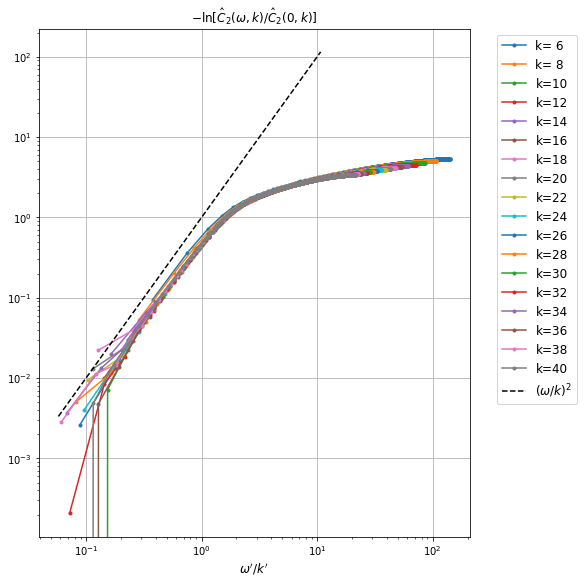

In [44]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
for ik in indices_of_k_to_plot :
    spectrum = np.absolute(spectrum_of_correlation[:, ik])
    norm_coef = spectrum[0]
    ax.plot(omega[1:t_length//2]/w0/(k[ik]/kL), -np.log(spectrum[1:t_length//2]/norm_coef), '.-', label='k=%2.f' % (k[ik]))
ax.plot(omega[1:t_length//4]/w0/(k[ik]/kL), 1.0*np.power(omega[1:t_length//4]/w0/(k[ik]/kL), 2.0), 'k--', label=r'$(\omega/k)^2$')


ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime / k^\prime$',title=r'$-\ln[\hat{C}_2 (\omega, k) / \hat{C}_2 (0, k)]$')
#ax.set(ylim=[5e-2, 10e0])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

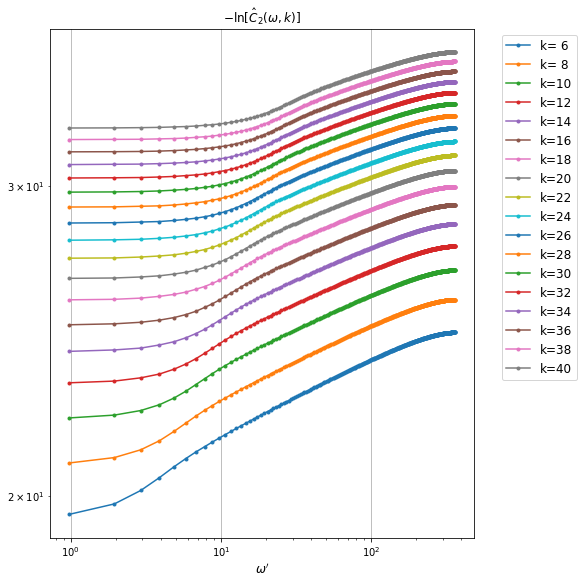

In [45]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
for ik in indices_of_k_to_plot :
    spectrum = np.absolute(spectrum_of_correlation[:, ik])
    norm_coef = 1.0
    #norm_coef = spectrum[0]
    ax.plot(omega[1:t_length//2]/w0, -np.log(spectrum[1:t_length//2]/norm_coef), '.-', label='k=%2.f' % (k[ik]))
#ax.plot(omega[1:t_length//2]/w0, 1.0*np.power(omega[1:t_length//4]/w0/(k[ik]/kL), 1.0), 'k--', label=r'$(\omega/k)^2$')

ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$',title=r'$-\ln[\hat{C}_2 (\omega, k)]$')
#ax.set(ylim=[5e-2, 10e0])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Amplitude at zero freq

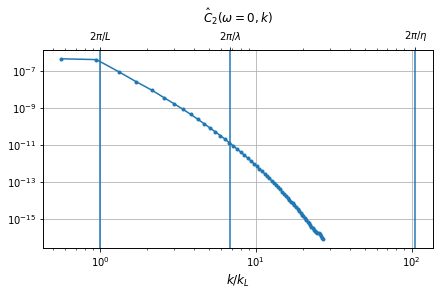

In [46]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k/kL, np.absolute(spectrum_of_correlation[0, :]), '.-', label='Spectrum')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', title=r'$\hat{C}_2(\omega=0,k)$')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

## Total time spectrum (sum over all k) + characteristic freq scales

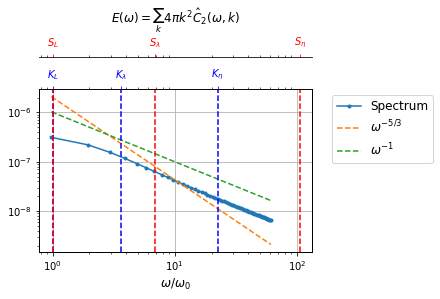

In [47]:
vertical_lines_kolmogorov = (wn_scales/kL)**(2.0/3.0) #non-dimensional frequecies corresponding to kolmogorov (local eddy turn-over) time scales
vertical_lines_sweeping = (wn_scales/kL) #non-dimensional frequecies corresponding to local sweeping time scales

fig, ax = plt.subplots(constrained_layout=True)
total_energy_spectrum = np.zeros(shape=spectrum_of_correlation.shape[0], dtype=float)
range_of_k = list(range(wavenumbers_length))
range_of_k = range(3,40)
for ik in range_of_k : 
    total_energy_spectrum = total_energy_spectrum + 4.0*np.pi*k[ik]*k[ik]*np.absolute(spectrum_of_correlation[:, ik])
    #total_energy_spectrum = total_energy_spectrum + spectrum
total_energy_spectrum = total_energy_spectrum/len(range_of_k)
ax.plot(omega[1:N//2]/w0, total_energy_spectrum[1:N//2], '.-', label='Spectrum')
ax.plot(omega[1:N//2]/w0, 2.0e-6*(omega[1:N//2]/w0)**(-5.0/3.0), '--',label=r'$\omega^{-5/3}$')
ax.plot(omega[1:N//2]/w0, 10e-7*(omega[1:N//2]/w0)**(-1.0), '--',label=r'$\omega^{-1}$')
for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
ax.set(xscale='log', yscale='log', xlabel=r'$\omega/\omega_0$', title=r'$E(\omega) = \sum_k 4 \pi k^2 \hat{C}_2(\omega, k)$'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
ax2.tick_params(axis='x', colors='blue')

ax3 = ax.twiny()
ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax3.spines["top"].set_position(("axes", 1.2))
ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
ax3.tick_params(axis='x', colors='red')

plt.show()

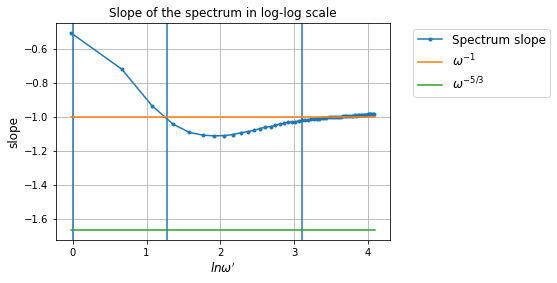

In [48]:
# check the slope of the spectrum
resampling = 1
x = np.log(omega[1:N//2:resampling]/w0)
f = np.log(total_energy_spectrum[1:N//2:resampling])
slope = np.gradient(f, x)

vertical_lines=np.log(vertical_lines_kolmogorov)
for line in vertical_lines : plt.axvline(x=line)
    
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
plt.xlabel(r'$ln \omega^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')
plt.grid()
plt.show()

# Integrated curves

<IPython.core.display.Javascript object>


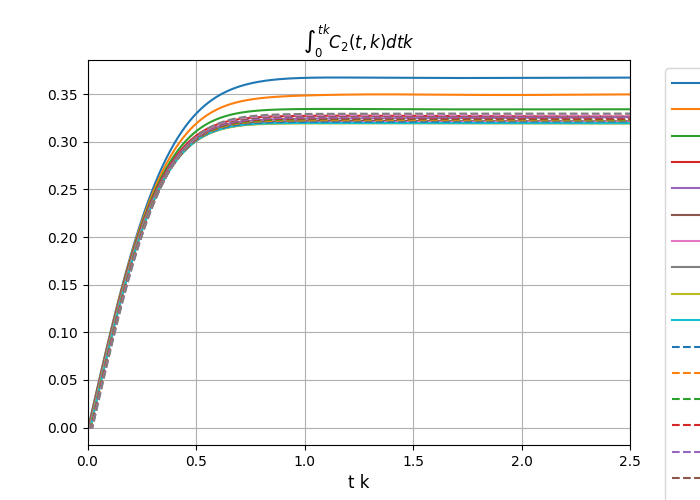

In [59]:
primitives = np.zeros_like(correlation_mean)   # COMPARE WITH ERROR FUNCTION

fig, ax = plt.subplots(figsize=(7,5))
for ik in indices_of_k_to_plot :
    #new_normalization = 1.0/correlation_mean[ic,ik]
    for it in list(range(t.shape[0])) :
        x=(t[0:it]/t0)*(k[ik]/kL)**1.0
        primitives[it,ik] = np.trapz(correlation_mean[0:it,ik]/correlation_mean[0,ik], x=x)
    ax.plot((t/t0)*(k[ik]/kL)**1.0, primitives[:,ik], label='k=%2.f' % (k[ik]))
ax.set(yscale='linear', title=r'$\int_0^{tk} C_2(t,k) d tk $'); ax.grid()
ax.set(xlim=[0,2.5])
#ax.set(ylim=[10e-5, 1.5])
ax.set(xlabel='t k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


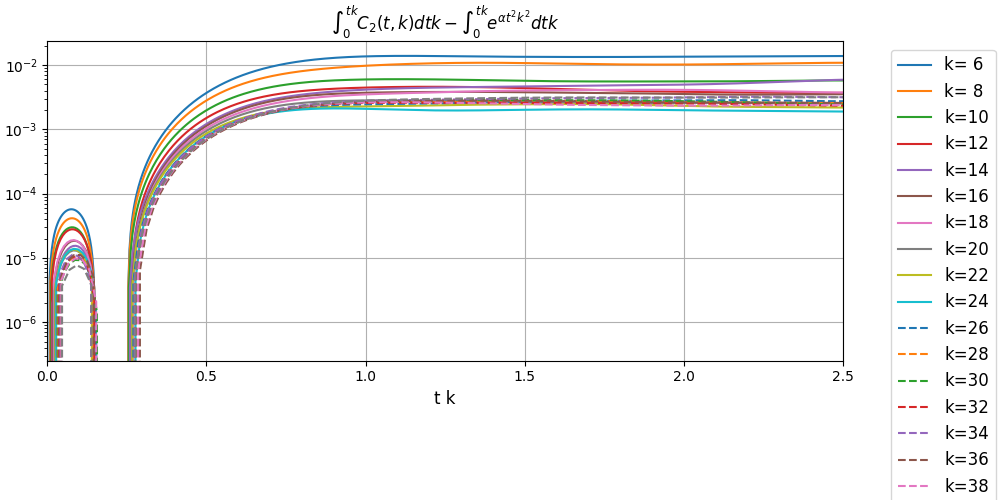

In [60]:
primitives_gaussian = np.zeros_like(correlation_mean)

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
for ik in indices_of_k_to_plot :
    #new_normalization = 1.0/correlation_mean[ic,ik]
    for it in list(range(t.shape[0])) :
        x=(t[0:it]/t0)*(k[ik]/kL)**1.0
        primitives_gaussian[it,ik] = np.trapz(gaussian(x, *optim_coef1[ik,:]), x=x)
    ax.plot((t/t0)*(k[ik]/kL)**1.0, primitives[:,ik] - primitives_gaussian[:,ik], label='k=%2.f' % (k[ik]))
ax.set(yscale='log', title=r'$\int_0^{tk} C_2(t,k) d tk  - \int_0^{tk} e^{\alpha t^2 k^2} d tk$'); ax.grid()
ax.set(xlim=[0,2.5])
#ax.set(ylim=[10e-5, 1.5])
ax.set(xlabel='t k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()